In [1]:
from torch.utils.data import Dataset, DataLoader 
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm
from functools import lru_cache
import albumentations as albu
from albumentations.pytorch import ToTensorV2

In [2]:
def get_transforms(train=False):
    if train:
        return albu.Compose(
            [
                albu.Flip(p=0.5),
                albu.ShiftScaleRotate(p=0.5),
                # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                albu.Normalize(mean=[0.0], std=[1.0]),
                # albu.ChannelShuffle(p=0.5),
                ToTensorV2(),
            ]
        )

    else:
        return albu.Compose(
            [
                albu.Normalize(mean=[0.0], std=[1.0]),
                ToTensorV2(),
            ]
        )


class PatchDataset(Dataset):
    def __init__(
            self, 
            volume_paths, 
            # mask_paths, 
            label_paths, 
            # ir_paths, 
            image_size=(256, 256), 
            train=True):
        self.volume_paths = volume_paths
        # self.mask_paths = mask_paths
        self.label_paths = label_paths
        # self.ir_paths = ir_paths
        # assert len(self.volume_paths) == len(self.mask_paths) == len(self.label_paths) == len(self.ir_paths)
        assert len(self.volume_paths) == len(self.label_paths)
        self.image_size = image_size
        assert (image_size[0] % 32 == 0) and (image_size[1] % 32 == 0)
        self.train = train
        self.transforms = get_transforms(train)
        self.VOLUME_Z = 65
        self.PATCH_SIZE = 32
        
    def __len__(self):
        if self.train:
            return len(self.volume_paths) // (self.image_size[0] // self.PATCH_SIZE * self.image_size[1] // self.PATCH_SIZE)
        else:
            return len(self.volume_paths)

    @lru_cache(maxsize=1024)
    def np_load(self, path):
        return np.load(path)

    def __getitem__(self, idx):
        volume = np.zeros((65, *self.image_size), dtype=np.float32)
        # ir = np.zeros((1, *self.image_size))
        # mask = np.zeros((1, *self.image_size))
        label = np.zeros(self.image_size)
        if self.train:
            idx = np.random.choice(np.arange(len(self.volume_paths)))
        volume_lt_path = self.volume_paths[idx]
        data_prefix = "/".join(volume_lt_path.split("/")[:-3])
        data_source = volume_lt_path.split("/")[-3]
        y, x = volume_lt_path.split("/")[-1].split(".")[-2].split("_")[-2:]
        x = int(x)
        y = int(y)
        for i in range(self.image_size[0] // self.PATCH_SIZE):
            for j in range(self.image_size[1] // self.PATCH_SIZE):
                volume_path = os.path.join(data_prefix, data_source, f"surface_volume/volume_{y + i}_{x + j}.npy")
                # mask_path = os.path.join(data_prefix, data_source, f"mask/mask_{y + i}_{x + j}.npy")
                # ir_path = os.path.join(data_prefix, data_source, f"ir/ir_{y + i}_{x + j}.npy")
                label_path = os.path.join(data_prefix, data_source, f"label/label_{y + i}_{x + j}.npy")
                if os.path.exists(volume_path):
                    volume[:, i * self.PATCH_SIZE: (i + 1) * self.PATCH_SIZE, j * self.PATCH_SIZE: (j + 1) * self.PATCH_SIZE] = self.np_load(volume_path)
                    # mask[:, i * self.PATCH_SIZE: (i + 1) * self.PATCH_SIZE, j * self.PATCH_SIZE: (j + 1) * self.PATCH_SIZE] = self.np_load(mask_path)
                    # ir[:, i * self.PATCH_SIZE: (i + 1) * self.PATCH_SIZE, j * self.PATCH_SIZE: (j + 1) * self.PATCH_SIZE] = self.np_load(ir_path)
                    label[i * self.PATCH_SIZE: (i + 1) * self.PATCH_SIZE, j * self.PATCH_SIZE: (j + 1) * self.PATCH_SIZE] = self.np_load(label_path)
        if self.transforms is None:
            volume = torch.tensor(volume)
            label = torch.tensor(label)
        else:
            volume = volume.transpose(1, 2, 0)
            aug = self.transforms(image=volume, mask=label)
            volume = aug["image"]
            label = aug["mask"]
        return (
            torch.tensor(volume), 
            # torch.tensor(ir),
            # torch.tensor(mask),
            torch.tensor(label), 
            torch.tensor(x), 
            torch.tensor(y), 
            torch.tensor(int(data_source))
            )

In [3]:
fragment_ids = [1, 2, 3] 
volume_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/surface_volume/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
# mask_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/mask/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
label_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/label/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
# ir_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/ir/**/*.npy", recursive=True))) for fragment_id in fragment_ids])


dataset = PatchDataset(volume_paths, label_paths, train=True)   

torch.Size([65, 256, 256]) torch.Size([256, 256]) tensor(152) tensor(34) tensor(1) tensor(0., dtype=torch.float64)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


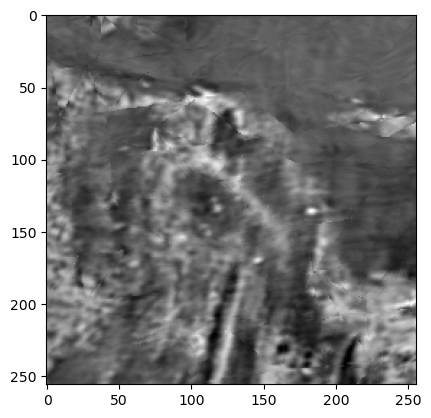

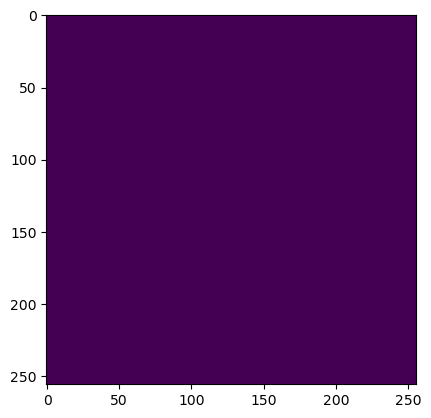

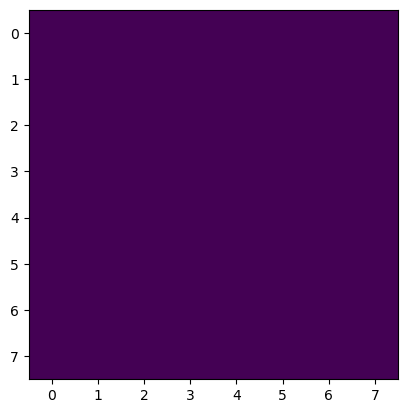

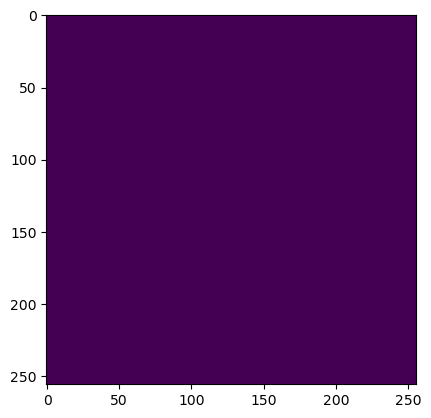

In [4]:
volume, label, x, y, data_source = dataset[100]
print(volume.shape, label.shape, x, y, data_source, label.sum())
plt.imshow(volume[0], cmap="gray")
plt.show()
plt.imshow(label)
plt.show()
# plt.imshow(ir[0])
# plt.show()
# label_mini = F.interpolate((label.reshape(1, 1, 256, 8, 32).sum(-1).reshape(1, 1, 8, 32, 8).sum(-2)  > (32 * 32 / 2)).float(), scale_factor=32)[0]
plt.imshow(F.interpolate(label[None, None, :], scale_factor=1/32, mode="bilinear", align_corners=True)[0, 0])
plt.show()
label_mini = F.interpolate(F.interpolate(label[None, None, :], scale_factor=1/32, mode="bilinear", align_corners=True), scale_factor=32, mode="bilinear", align_corners=True)[0, 0]
# label_mini = F.interpolate(label[None, :], scale_factor=1/32, mode="bilinear", align_corners=True)[0]
plt.imshow(label_mini)
plt.show()

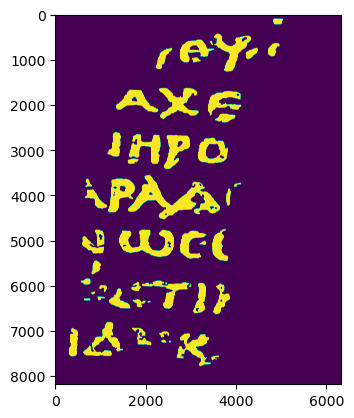

In [5]:
import PIL.Image as Image

fragment_ids = [1] 
label_all = np.array(Image.open(f"../../input/vesuvius-challenge-ink-detection/train/{fragment_ids[0]}/inklabels.png").convert("1"))
volume_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/surface_volume/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
# mask_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/mask/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
label_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/label/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
# ir_paths = np.concatenate([np.asarray(sorted(glob(f"../../input/vesuvius_patches_32/train/{fragment_id}/ir/**/*.npy", recursive=True))) for fragment_id in fragment_ids])
dataset = PatchDataset(volume_paths, label_paths, train=False)   
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, drop_last=False)
plt.imshow(label_all)

In [6]:
pred_all = np.zeros_like(label_all, dtype=np.float32)
count_map = np.zeros_like(label_all, dtype=np.float32)
for data in tqdm(dataloader):
    volume, label, x, y, data_source = data
    # pred = F.interpolate((label.reshape(16, 1, 256, 8, 32).sum(-1).reshape(16, 1, 8, 32, 8).sum(-2)  > (32 * 32 / 2)).float(), scale_factor=32)
    pred = F.interpolate(F.interpolate(label[:, None], scale_factor=1/32, mode="bilinear", align_corners=True), scale_factor=32, mode="bilinear", align_corners=True)
    for xi, yi, pi in zip(x, y, pred):
        y_lim, x_lim = pred_all[yi * 32 : yi * 32 + 256, xi * 32 : xi * 32 + 256].shape
        pred_all[yi * 32 : yi * 32 + 256, xi * 32 : xi * 32 + 256] += pi[0, :y_lim, :x_lim].float().numpy()
        count_map[yi * 32 : yi * 32 + 256, xi * 32 : xi * 32 + 256] += np.ones_like(pi[0, :y_lim, :x_lim].numpy())
pred_all /= count_map
pred_all = np.nan_to_num(pred_all)



  0%|          | 0/1822 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.9841738717030705
0.21898643200948187


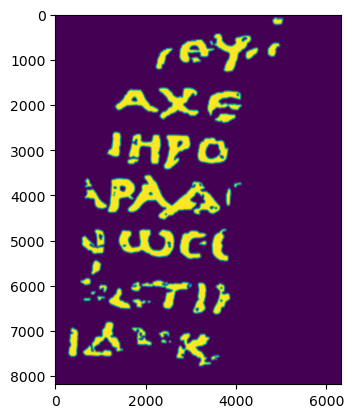

In [7]:
plt.imshow(pred_all)

def fbeta_score(
    targets: np.ndarray, preds: np.ndarray, beta: float = 0.5, smooth: float = 1e-6
):
    if targets.sum() == 0 and preds.sum() == 0:
        return 1.0
    y_true_count = targets.sum()
    ctp = (preds * targets).sum()
    cfp = (preds * (1 - targets)).sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    fbeta = (
        (1 + beta_squared)
        * (c_precision * c_recall)
        / (beta_squared * c_precision + c_recall + smooth)
    )

    return fbeta    
print(fbeta_score(label_all, pred_all > 0.5))
print(fbeta_score(label_all, np.array(Image.open(f"../../input/vesuvius-challenge-ink-detection/train/{fragment_ids[0]}/mask.png").convert("1"))))